In [1]:
import matplotlib.pyplot as plt
import muse.util as muse
import numpy as np
import pyroomacoustics as pra
from pyroomacoustics.directivities import CardioidFamily, DirectionVector, DirectivityPattern
from scipy.io import wavfile
import seaborn as sns
import librosa
from scipy.spatial import distance

%pylab inline

def generate_room(x_dim, y_dim, z_dim, sampling_rate=125000, plot=False):
    # generate the showbox using pyroom acoustics
    # Materials of the room's walls
    # See different materials at https://pyroomacoustics.readthedocs.io/en/pypi-release/pyroomacoustics.materials.database.html
    materials = pra.make_materials(
        ceiling = "fibre_absorber_2",
        floor   = "fibre_absorber_2",
        east    = "hard_surface",
        west    = "hard_surface",
        north   = "hard_surface",
        south   = "hard_surface"
    )
    
    shoebox_object = pra.ShoeBox(
        [x_dim, y_dim, z_dim],
        fs=sampling_rate,
        materials=materials,
        max_order=9  # Maximum number of times a sound wave can reflect (?)
    ) 
    return shoebox_object

def place_mics(shoebox, mic_pos):
    # Assuming mic_pos has shape (3, n_mics), which, while strange, is what MUSE expects
    # I think this is just a side-effect of MATLAB matrix convention
    mic_pos = mic_pos.T  # (3, n_mics) -> (n_mics, 3)
    shoebox_dims = shoebox.shoebox_dim
    if any([coord >= box_size for coord, box_size in zip(mic_pos.max(axis=0), shoebox_dims)]) \
        or any([coord <= 0 for coord in mic_pos.min(axis=0)]):
        raise ValueError("The microphones must be within the box. They cannot be located along an egde or face.")
    
    # Compute directivity of microphones
    # Assumes the microphones are all pointed toward the center of the room's floor
    # Can be simplified by just pointing them downward
    room_center = np.array(shoebox_dims) / 2
    room_center[2] = 0
    
    mic_directions = room_center[np.newaxis, ...] - mic_pos  # List of vectors pointing from each mic to room_center
    mic_directions /= np.sqrt((mic_directions**2).sum(axis=1, keepdims=True))  # Normalize the vectors
    
    # Convert the direction vectors into polar coordinates for the directivities used by PRA
    directivities = list()
    for direction in mic_directions:
        # Angle within the x-y plane. 0 radians is toward the positive x direction
        # In spherical coordinates, this is \theta
        azimuth = np.arctan2(direction[1], direction[0])
        # Same thing here, but between the z axis and the x-y plane
        xy_vec_size = np.sqrt((direction[:2] ** 2).sum())
        # Using arctan instead of arctan2 because I need the result to be within Q1 and Q4
        # This would be called \phi in spherical coordinates
        colatitude = np.pi/2 - np.arctan(direction[2] / xy_vec_size)
        pra_direction = DirectionVector(
            azimuth=azimuth,
            colatitude=colatitude,
            degrees=False
        )
        # For visualizations, see https://en.wikipedia.org/wiki/Microphone#Polar_patterns
        # For supported options, see https://pyroomacoustics.readthedocs.io/en/pypi-release/pyroomacoustics.directivities.html?highlight=DirectivityPattern#pyroomacoustics.directivities.DirectivityPattern
        directivities.append(CardioidFamily(
            orientation=pra_direction,
            pattern_enum=DirectivityPattern.HYPERCARDIOID
        ))
    
    # Transpose mic_pos back to (3, n_mics)
    shoebox.add_microphone_array(mic_array=mic_pos.T, directivity=directivities)
    
def add_source(speaker_pos, stimulus, sr_stimulus, room):
    if not isinstance(speaker_pos, list):
        speaker_pos = list(speaker_pos)
    
    if room.fs != sr_stimulus:
        print('resampling audio')
        stimulus_resampled = librosa.resample(stimulus.astype('float'), orig_sr=sr_stimulus, 
                                                                      target_sr=room.fs)
        room.add_source(speaker_pos, signal=stimulus_resampled, delay=0)
        return room.fs, stimulus_resampled
        
    else:
        room.add_source(speaker_pos, signal=stimulus, delay=0)
        return sr_stimulus, stimulus

Populating the interactive namespace from numpy and matplotlib


In [2]:
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('talk')

# 1. Setup virtual environment

#### parameters

In [3]:
sr = 125000 #audio sampling rate

#room dimensions
x_dim = 1.83
y_dim = 2.44
z_dim = 0.76

#microphone positions

#to place in top corners, otherwise, put in x,y,z coords 
offset = .1
mic_pos = np.array([
    [x_dim-offset, y_dim-offset, z_dim-offset],
    [offset, offset, z_dim-offset],
    [offset, y_dim-offset, z_dim-offset],
    [x_dim-offset, offset, z_dim-offset]
]).T

#pack stimulus to play in room
import os
sr_stimulus, stimulus = wavfile.read(os.path.abspath('../stimuli/tones/sine_2khz.wav'))

#position of speaker in room
x_pos, y_pos, z_pos = 0.8, 1.14, 0.01

#### generate room

In [4]:
room = generate_room(x_dim, y_dim, z_dim, plot=False)

#### visualize room

In [15]:
%matplotlib widget

axes_offset = 0.5

sns.set_style('white')
sns.set_style('ticks')
sns.set_context('paper')

fig, ax = room.plot()
ax.set_xlim([-axes_offset, x_dim+axes_offset])
ax.set_ylim([-axes_offset, y_dim+axes_offset])
ax.set_zlim([-axes_offset, z_dim+axes_offset]);

ax.set_xlabel('Width (m)', labelpad=10)
ax.set_ylabel('Length (m)', labelpad=10)
ax.set_zlabel('Height (m)', labelpad=10);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

#### add mics to room

In [6]:
place_mics(room, mic_pos)

#### vizualize mics in room

In [7]:
%matplotlib widget

axes_offset = 0.5

sns.set_style('white')
sns.set_style('ticks')
sns.set_context('paper')

fig, ax = room.plot(plot_directivity=False, mic_marker_size=50)
ax.set_xlim([-axes_offset, x_dim+axes_offset])
ax.set_ylim([-axes_offset, y_dim+axes_offset])
ax.set_zlim([-axes_offset, z_dim+axes_offset]);

ax.set_xlabel('Width (m)', labelpad=10)
ax.set_ylabel('Length (m)', labelpad=10)
ax.set_zlabel('Height (m)', labelpad=10);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

#### play a stimulus from a speaker

In [8]:
speaker_pos = (x_pos, y_pos, z_pos)
sr_stimulus, stimulus = add_source(speaker_pos, stimulus, sr_stimulus, room)

resampling audio


In [9]:
%matplotlib widget

axes_offset = 0.5

sns.set_style('white')
sns.set_style('ticks')
sns.set_context('paper')

fig, ax = room.plot(plot_directivity=False, mic_marker_size=50)

ax.plot3D(x_pos, y_pos, z_pos, marker='o', color='k', markersize=10)

ax.set_xlim([-axes_offset, x_dim+axes_offset])
ax.set_ylim([-axes_offset, y_dim+axes_offset])
ax.set_zlim([-axes_offset, z_dim+axes_offset]);


ax.set_xlabel('Width (m)', labelpad=10)
ax.set_ylabel('Length (m)', labelpad=10)
ax.set_zlabel('Height (m)', labelpad=10);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

#### run the simulation

In [10]:
room.simulate()

#### output of the simunlation

Populating the interactive namespace from numpy and matplotlib


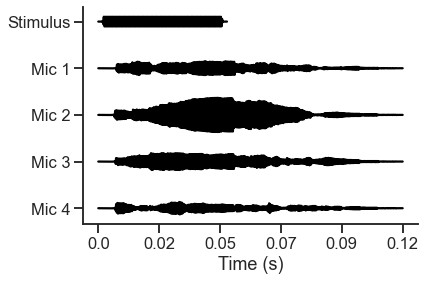

In [11]:
%pylab inline

sns.set_style('white')
sns.set_style('ticks')
sns.set_context('talk')

tick_labels = ["Stimulus"]

plot(stimulus, 'k')
for i in range(room.mic_array.signals.shape[0]):
    plot(room.mic_array.signals[i]-(i+1)*10000, 'k')
    tick_labels.append('Mic {}'.format(i+1))
#     yticks('')

xticks(np.arange(room.mic_array.signals.shape[1])[::int(room.mic_array.signals.shape[1]/5)],
       np.around(np.arange(room.mic_array.signals.shape[1])[::int(room.mic_array.signals.shape[1]/5)]/sr, decimals=2))
yticks(np.arange(0,room.mic_array.signals.shape[0]+1)*-10000,
      tick_labels)
xlabel('Time (s)')
sns.despine()

# 2. Run MUSE on simulated data

#### MUSE parameters

In [12]:
#create grid to predict sound source over
x_grid, y_grid = muse.make_xy_grid(x_dim, y_dim, resolution=0.0025)  # I increased this ten-fold because it took forever to run
in_cage = None  # unused argument

#x, y, zmic positions
R = mic_pos

#audio from mic array from simulation
audio = room.mic_array.signals.T  # Transpose shape from (n_mics, n_samp) to (n_samp, n_mics)

#frequency range of interest
f_lo = 0
f_hi = 62500

fs = sr #audio sampling rate
dt = 1 / fs #time step
temp = 20 #temperature oF environment (C)

N, n_mics = audio.shape #num mics

#### Run Muse

In [13]:
r_est, _, rsrp_grid, _, _, _, _, _, _ \
= muse.r_est_from_clip_simplified(audio,
    fs,
    f_lo,
    f_hi,
    temp,
    x_grid,
    y_grid,
    in_cage,
    R,  # Expected to have shape (3, n_mics)
    1)

#### Visualize and compute error

In [14]:
%matplotlib widget

axes_offset = 0.5

sns.set_style('white')
sns.set_style('ticks')
sns.set_context('paper')

fig, ax = room.plot(plot_directivity=False, mic_marker_size=50,img_order=-1)


ax.plot3D(x_pos, y_pos, z_pos, marker='o', color='k', markersize=5)
ax.plot3D(r_est[0], r_est[1], 0, marker='o', color='r', markersize=5)

ax.set_xlim([-axes_offset, x_dim+axes_offset])
ax.set_ylim([-axes_offset, y_dim+axes_offset])
ax.set_zlim([-axes_offset, z_dim+axes_offset]);


ax.set_xlabel('Width (m)', labelpad=10)
ax.set_ylabel('Length (m)', labelpad=10)
ax.set_zlabel('Height (m)', labelpad=10);

print('MUSE error (m):', np.around(distance.euclidean(r_est, speaker_pos[:2]), decimals=3))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

MUSE error (m): 0.495
